In [1]:
import pandas as pd
import numpy as np
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
pd.reset_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 500)


warnings.filterwarnings(action='ignore')

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

In [3]:
df = spark.read.parquet('gs://ads-sjhuang-final/notebooks/sjhuang/sample01')

In [4]:
df = df.withColumn("is_data_science_commit",
                 when(col("subject").rlike(r"(?i)\bmodel\b|\btrain\b|\bdata\b|\bAI\b"), True).otherwise(False))
data_science_commits = df.filter(col("is_data_science_commit") == True)

In [5]:
data_science_commits.limit(5)

repo_name,commit,author_name,timestamp,subject,message,date,name,license,is_data_science_commit
007slm/kissy,ac6153b0fd73abe3d...,yiminghe,1362478614,support data when...,support data when...,2013-03-05,[],mit,true
12yujim/pymtl,69b5255be5e3d1183...,Derek Lockhart,1393710026,[pymtl] replace @...,[pymtl] replace @...,2014-03-01,"[Assembly, C, Coq...",bsd-3-clause,true
AD5GB/android_ker...,9155f82a6a26da4a5...,Takashi Iwai,1329759662,ALSA: hda/realtek...,ALSA: hda/realtek...,2012-02-20,"[ASP, Assembly, A...",gpl-2.0,true
AD5GB/android_ker...,7745384080ef70f77...,Zhang Rui,1224222161,don't load asus-a...,don't load asus-a...,2008-10-17,"[ASP, Assembly, A...",gpl-2.0,true
AD5GB/android_ker...,dbb442b85a1d82f91...,Greg Kroah-Hartman,1292543550,"Revert ""USB: gadg...","Revert ""USB: gadg...",2010-12-16,"[ASP, Assembly, A...",gpl-2.0,true


In [6]:
lang_df = data_science_commits.filter(size(col("name")) > 0)\
            .withColumn("language", explode(col("name")))
lang_df = lang_df.groupBy("language").count().orderBy("count", ascending=False)
lang_df.limit(10)

language,count
Shell,327392
Python,301701
C++,267723
C,264915
Perl,250766
Objective-C,245933
Assembly,235580
Makefile,229675
Awk,217706
UnrealScript,203299


In [7]:
year_lang_df = data_science_commits.filter(size(col("name")) > 0)\
                 .withColumn("language", explode(col("name")))\
                 .withColumn('year', year(col("date")))

In [8]:
from pyspark.sql.window import Window
# Group by year and language to calculate the count of each language per year
lang_year_df = year_lang_df.filter(col("year") < 2023).groupBy("year", "language").count()

# Define a window specification to rank languages by count for each year
window_spec = Window.partitionBy("year").orderBy(col("count").desc())

# Add a rank column to determine the top 3 languages per year
ranked_lang_df = lang_year_df.withColumn("rank", rank().over(window_spec))

# Filter for the top 3 languages per year
top3_lang_per_year = ranked_lang_df.filter(col("rank") <= 5).orderBy("year", "rank")

# Show the result
top3_lang_per_year.show(50, truncate=False)

+----+----------+-----+----+
|year|language  |count|rank|
+----+----------+-----+----+
|2008|Shell     |31788|1   |
|2008|Python    |31342|2   |
|2008|C         |29873|3   |
|2008|C++       |29754|4   |
|2008|Perl      |29540|5   |
|2009|Shell     |26930|1   |
|2009|Python    |25420|2   |
|2009|C         |25198|3   |
|2009|C++       |24997|4   |
|2009|Perl      |24529|5   |
|2010|Shell     |51219|1   |
|2010|Python    |49233|2   |
|2010|C++       |47870|3   |
|2010|C         |47100|4   |
|2010|Perl      |45371|5   |
|2011|Shell     |59766|1   |
|2011|Python    |58507|2   |
|2011|C++       |54584|3   |
|2011|C         |54104|4   |
|2011|Perl      |52436|5   |
|2012|Shell     |40893|1   |
|2012|Python    |38995|2   |
|2012|C++       |35831|3   |
|2012|C         |35344|4   |
|2012|Perl      |34656|5   |
|2013|Shell     |33888|1   |
|2013|Python    |30894|2   |
|2013|C++       |26732|3   |
|2013|C         |26311|4   |
|2013|Makefile  |25712|5   |
|2014|Shell     |33683|1   |
|2014|Python  

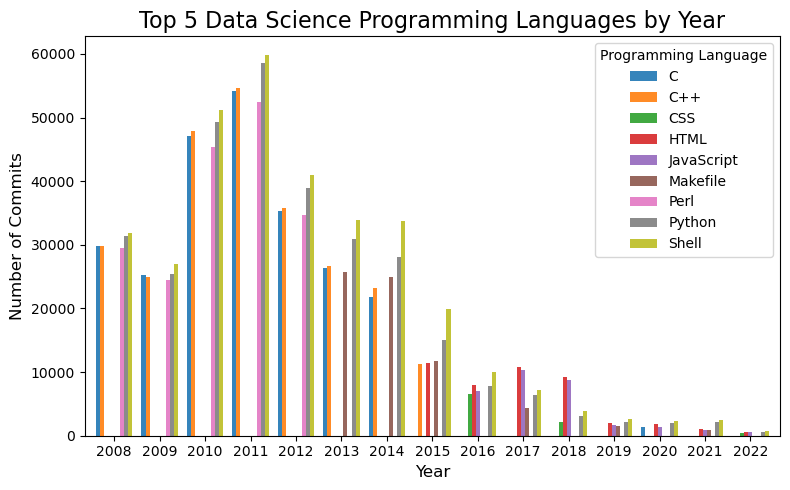

In [10]:
year_pd_df = top3_lang_per_year.toPandas()

# Pivot the DataFrame to prepare it for visualization
pivot_df = year_pd_df.pivot(index="year", columns="language", values="count").fillna(0)

# Plot the grouped bar chart
pivot_df.plot(kind="bar", figsize=(8, 5), width=0.8, alpha=0.9)

# Add titles and labels
plt.title("Top 5 Data Science Programming Languages by Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Commits", fontsize=12)

# Customize x-axis
plt.xticks(rotation=0, fontsize=10)

# Add legend
plt.legend(title="Programming Language", fontsize=10)

# Display the chart
plt.tight_layout()
plt.show()